# Robótica Móvel - Trabalho Prático 1
---
**Nome Completo:** Daniel Terra Gomes

**Matrícula:** 2025702870 

**Programa:** Mestrando do PPGCC
**Departamento:** Departamento de Ciência da Computação
**Instituição:** ICEx-UFMG
**E-mail:** danielterragomes@ufmg.br

**Data:** 11 de setembro de 2025

---

## Exercício 1: Criação da Cena no CoppeliaSim

O primeiro passo foi criar uma cena no CoppeliaSim contendo um robô móvel (Pioneer 3DX) e cinco outros objetos distintos (pessoa, mesa, cadeira, planta, e caixote) para popular o ambiente de simulação. A imagem abaixo documenta a cena criada.

![CoppeliaSim Scene](Screenshot%20from%202025-09-04%2009-26-53.png)

*Figura 1: Cena criada no CoppeliaSim contendo o robô Pioneer 3DX e cinco objetos distintos (pessoa, mesa, cadeira, planta, e caixote)*

## Exercício 2: Diagrama de Transformações

O diagrama a seguir representa as relações entre os sistemas de coordenadas dos objetos na cena. O frame do Mundo {W} serve como referência global. 

![Transformation Diagram](ex2-diagram.drawio.png)

*Figura 2: Diagrama de transformações mostrando o sistema de coordenadas do ex.1 e as relações entre os diferentes sistemas de coordenadas na cena. As setas sólidas (Verdes) representam transformações diretas do objeto conhecidos, enquanto a seta (Vermelha) mostra uma transformação desejada (Desconhecida).*



## Exercise 3: Spatial Transformation Implementation


In [113]:
import numpy as np
import math
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional, Any
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

# Configuration constants
# Set a name for the object > Name of the object in CoppeliaSim Scene
OBJECT_MAPPING = {
    'Robot': 'RobotnikSummitXL',
    'Bill_0': 'Bill[0]',
    'Bill_1': 'Bill[1]',
    'Crate': 'Floor/ConcretBlock',
    'Pillar_0': 'Floor/20cmHighPillar10cm[0]',
    'Pillar_1': 'Floor/20cmHighPillar10cm[1]',
    'Table': 'diningTable',
    'Laptop_0': 'diningTable/laptop[0]',
    'Laptop_1': 'diningTable/laptop[1]',
    'Fence_0': 'Floor/20cmHighWall100cm[0]',
    'Fence_1': 'Floor/20cmHighWall100cm[1]'
}

class CoppeliaSimConnector:
    """Handles connection and communication with CoppeliaSim simulator."""

    def __init__(self):
        self.client = None
        self.sim = None
        self.object_handles = {}

    def connect(self) -> bool:
        """Establish connection to CoppeliaSim."""
        try:
            self.client = RemoteAPIClient()
            self.sim = self.client.require('sim')
            return True
        except Exception as e:
            print(f"Connection failed: {e}")
            return False

    def discover_objects(self) -> Dict[str, int]:
        """Discover and map objects in the scene."""
        try:
            all_objects = self.sim.getObjectsInTree(self.sim.handle_scene)
            scene_objects = {}

            for handle in all_objects:
                try:
                    name = self.sim.getObjectAlias(handle, 1)
                    if not name:
                        name = self.sim.getObjectName(handle)
                    if name:
                        scene_objects[name.strip()] = handle
                except:
                    continue

            # Map expected objects to actual scene objects
            for expected_name, pattern in OBJECT_MAPPING.items():
                for scene_name, handle in scene_objects.items():
                    if pattern in scene_name:
                        self.object_handles[expected_name] = handle
                        break

            return self.object_handles

        except Exception as e:
            print(f"Object discovery failed: {e}")
            return {}

    def get_object_pose(self, object_name: str, reference_frame: Optional[str] = None) -> Optional[Tuple[np.ndarray, np.ndarray]]:
        """Get position and orientation of an object."""
        if object_name not in self.object_handles:
            return None

        try:
            handle = self.object_handles[object_name]
            ref_handle = self.sim.handle_world

            if reference_frame and reference_frame in self.object_handles:
                ref_handle = self.object_handles[reference_frame]

            position = np.array(self.sim.getObjectPosition(handle, ref_handle))
            orientation = np.array(self.sim.getObjectOrientation(handle, ref_handle))

            return position, orientation

        except Exception as e:
            print(f"Failed to get pose for {object_name}: {e}")
            return None

# Initialize connection
connector = CoppeliaSimConnector()
if connector.connect():
    object_handles = connector.discover_objects()
    print(f"Connected to CoppeliaSim. Found {len(object_handles)} objects.")
    for name, handle in object_handles.items():
        print(f"  {name}: Handle {handle}")
else:
    print("Failed to connect to CoppeliaSim.")

Connected to CoppeliaSim. Found 11 objects.
  Robot: Handle 89
  Bill_0: Handle 56
  Bill_1: Handle 130
  Crate: Handle 25
  Pillar_0: Handle 29
  Pillar_1: Handle 49
  Table: Handle 118
  Laptop_0: Handle 122
  Laptop_1: Handle 126
  Fence_0: Handle 17
  Fence_1: Handle 21


In [114]:
# Get robot pose and orientation
robot_pose = connector.get_object_pose('Robot')

if robot_pose:
  position, orientation = robot_pose
  print("Robot Pose:")
  print(f"Position (x, y, z): {position}")
  print(f"Orientation (rx, ry, rz): {orientation}")
  print(f"Position in meters: [{position[0]:.3f}, {position[1]:.3f}, {position[2]:.3f}]")
  print(f"Orientation in radians: [{orientation[0]:.3f}, {orientation[1]:.3f}, {orientation[2]:.3f}]")
else:
  print("Failed to get robot pose")

Robot Pose:
Position (x, y, z): [ 2.45636004 -2.31136391  0.30902216]
Orientation (rx, ry, rz): [1.39031424e-03 3.44023322e-04 2.44329237e+00]
Position in meters: [2.456, -2.311, 0.309]
Orientation in radians: [0.001, 0.000, 2.443]


In [116]:
# Utility functions for transformations
def Rz(theta):
    """Creates a 3x3 rotation matrix around the Z-axis."""
    return np.array([[np.cos(theta), -np.sin(theta), 0],
                     [np.sin(theta),  np.cos(theta), 0],
                     [0,              0,             1]])

def Ry(theta):
    """Creates a 3x3 rotation matrix around the Y-axis."""
    return np.array([[np.cos(theta),  0, np.sin(theta)],
                     [0,              1, 0],
                     [-np.sin(theta), 0, np.cos(theta)]])

def Rx(theta):
    """Creates a 3x3 rotation matrix around the X-axis."""
    return np.array([[1, 0,              0],
                     [0, np.cos(theta), -np.sin(theta)],
                     [0, np.sin(theta),  np.cos(theta)]])

def create_homogeneous_matrix(position: np.ndarray, euler_angles: np.ndarray) -> np.ndarray:
    """
    Creates a 4x4 homogeneous transformation matrix from position and Euler angles.
    Based on aula04-descricao-espacial-transformacoes-rigidas.pdf, page 35.
    """
    alpha, beta, gamma = euler_angles
    # Rotation matrix from Z-Y-X Euler angles
    R = Rz(alpha) @ Ry(beta) @ Rx(gamma)

    # Create the 4x4 homogeneous matrix
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = position
    return T

def invert_homogeneous_matrix(T: np.ndarray) -> np.ndarray:
    """
    Efficiently inverts a 4x4 homogeneous transformation matrix.
    Based on aula05-transformacoes-homogeneas-espaco-configuracoes.pdf, page 16.
    """
    R = T[:3, :3]
    P = T[:3, 3]

    R_inv = R.T
    P_inv = -R_inv @ P

    T_inv = np.eye(4)
    T_inv[:3, :3] = R_inv
    T_inv[:3, 3] = P_inv
    return T_inv

In [117]:
def plot_frame(Porg: np.ndarray, R: np.ndarray, c: Optional[List[str]] = None, label: Optional[str] = None):
    """Plots a 2D coordinate frame."""
    axis_size = 0.5
    axes = axis_size * R

    x_axis = np.array(axes[0:2, 0])
    y_axis = np.array(axes[0:2, 1])

    if c is None:
        c = ['r', 'g']

    # The X-axis uses the first color (c[0]) and gets the label for the legend
    plt.quiver(*Porg[0:2], *x_axis, color=c[0], angles='xy', scale_units='xy', scale=1, label=label)

    # The Y-axis must use the second color (c[1])
    plt.quiver(*Porg[0:2], *y_axis, color=c[1], angles='xy', scale_units='xy', scale=1)

    if label:
        plt.text(Porg[0], Porg[1] + 0.1, label, fontsize=9)

In [118]:

def calculate_and_plot_relative_poses(connector: CoppeliaSimConnector, object_handles: Dict[str, int], scenario_title: str):
    """Calculates and plots the poses of all objects relative to the robot."""
    fig, ax = plt.subplots(figsize=(10, 10))

    ax.set_title(f"Object Poses from the Robot's Perspective {{R}}\n{scenario_title}")

    ax.set_xlabel("X-axis (meters)")
    ax.set_ylabel("Y-axis (meters)")
    ax.grid(True)

    plot_frame(np.array([0, 0, 0]), np.eye(3), label="Robot {R}")

    robot_pose_global = connector.get_object_pose('Robot')
    if robot_pose_global:
        T_W_R = create_homogeneous_matrix(*robot_pose_global)
        T_R_W = invert_homogeneous_matrix(T_W_R)

        for name in object_handles.keys():
            if name == 'Robot': continue

            object_pose_global = connector.get_object_pose(name)
            if object_pose_global:
                T_W_O = create_homogeneous_matrix(*object_pose_global)
                T_R_O = T_R_W @ T_W_O
                pos_O_R = T_R_O[:3, 3]
                R_O_R = T_R_O[:3, :3]

                plot_frame(pos_O_R, R_O_R, label=name)
                ax.quiver(0, 0, pos_O_R[0], pos_O_R[1], angles='xy', scale_units='xy', scale=1, color='gray', linestyle='--')

    ax.axis('equal')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

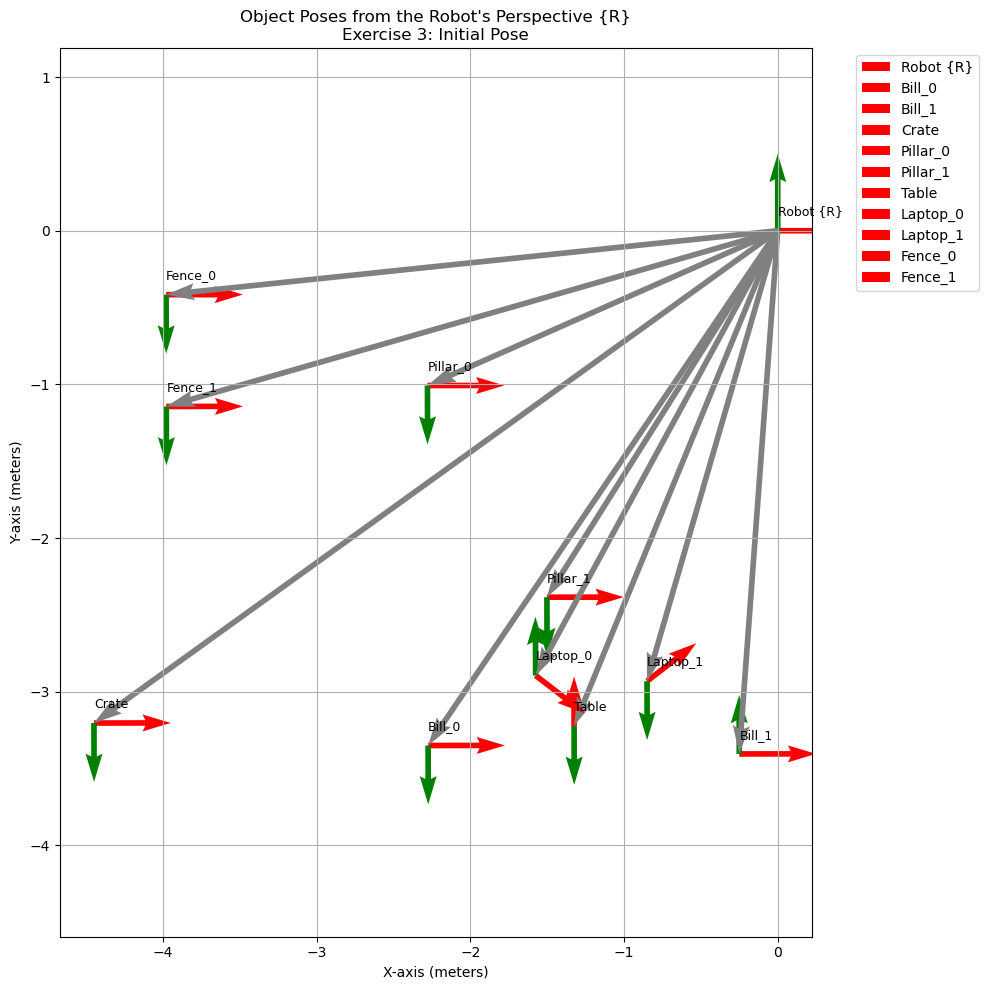

In [119]:
calculate_and_plot_relative_poses(connector, object_handles, "Exercise 3: Initial Pose")


# EX4

--- Generating Plot for Scenario A: Side Pose A ---


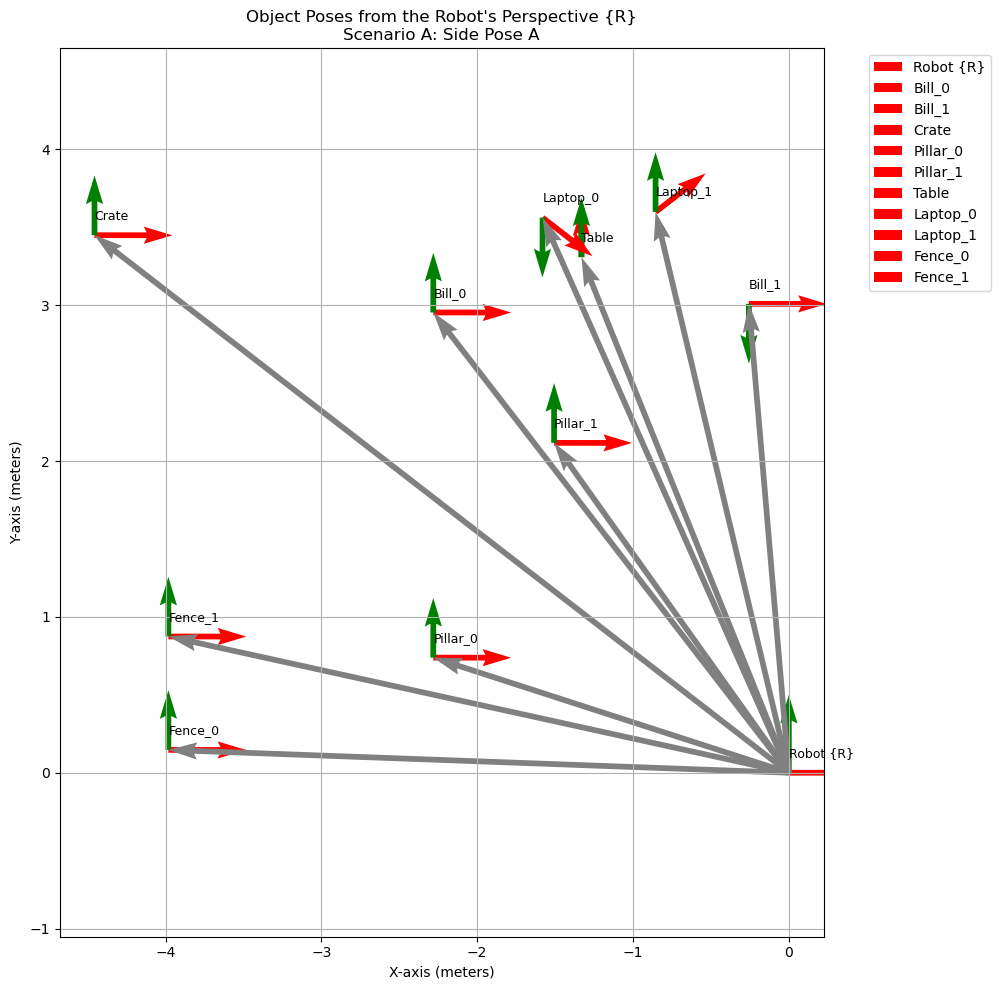

In [121]:
print("--- Generating Plot for Scenario A: Side Pose A ---")
calculate_and_plot_relative_poses(connector, object_handles, "Scenario A: Side Pose A")

\n--- Generating Plot for Scenario B: Side Pose B ---


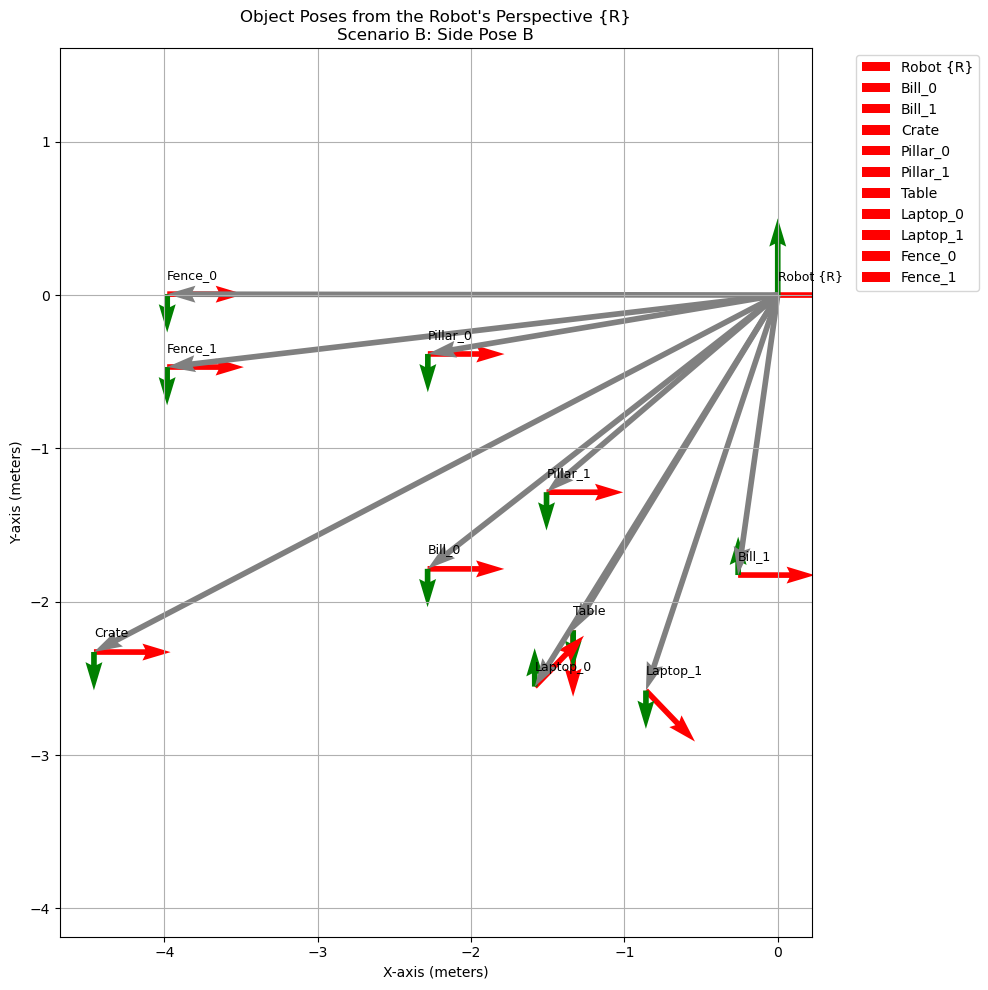

In [123]:
print("\\n--- Generating Plot for Scenario B: Side Pose B ---")
calculate_and_plot_relative_poses(connector, object_handles, "Scenario B: Side Pose B")

\n--- Generating Plot for Scenario C: Rear Pose (180° Rotation) ---


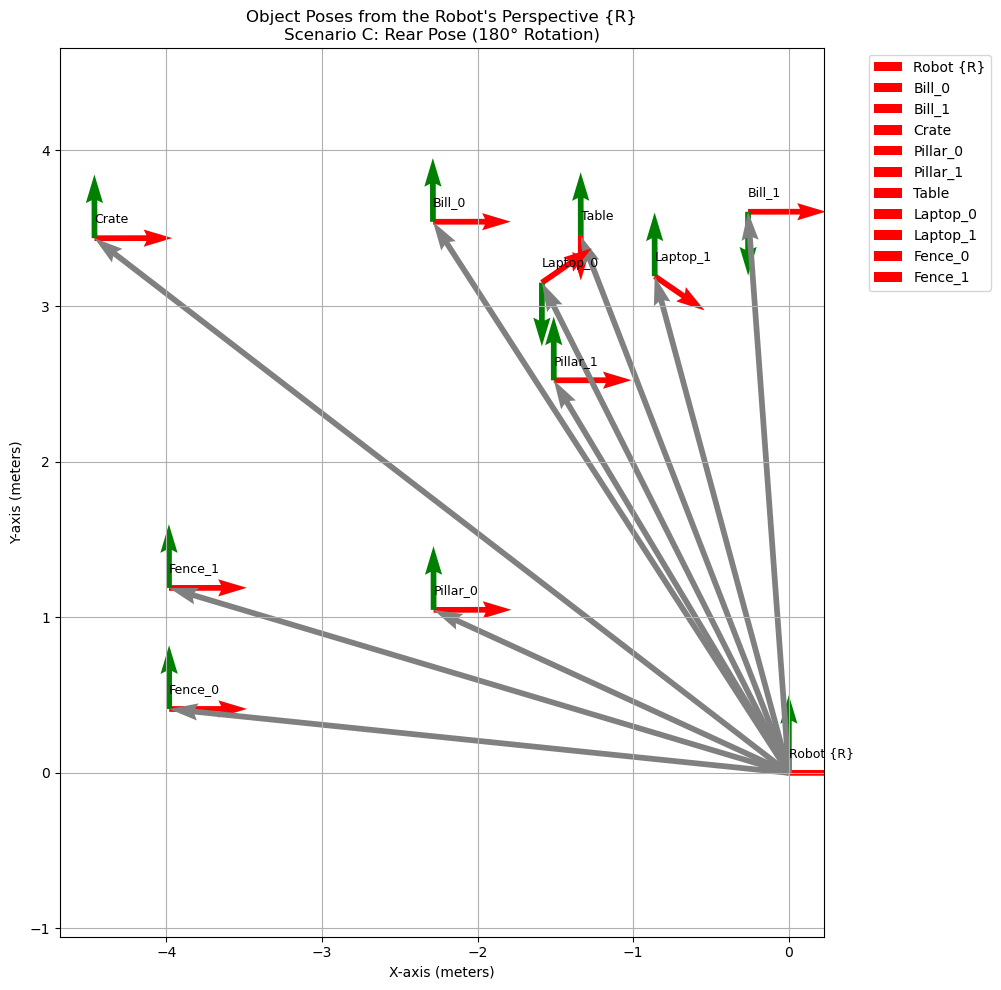

In [ ]:
print("\\n--- Generating Plot for Scenario C: Rear Pose (180° Rotation) ---")
calculate_and_plot_relative_poses(connector, object_handles, "Scenario C: Rear Pose (180° Rotation)")